# Synthetic Handwritten Text Generation Using RNN Based Deep Learning Models

Handwriting is one of those innate capabilities which makes us stand as unique individuals. Handwriting styles are so unique that they have been studied in quite detail to understand personalities, identification, forensics and so on.

Yet if we see objectively, handwriting is simply a movement of pen over paper tracing well defined shapes (more formally alphabets of a given language).

## `
<img src="assets/hw001.jpeg">

### Realistic Handwritten Content

Since the advent of computers, we have been trying to automate most manual tasks, writing being one of them. Today we have numerous fonts to capture the context, mood and style of the writer. There are fonts which try to mimic handwriting styles, yet they fall short. 

### To Understand Data Generation Processes

In most Machine Learning/Deep Learning problems, we approximate the function which transforms input data points to required output. There is another class of problems where we try to model the data generation process itself, thus making it easier to understand the data and its properties.

Handwriting is nothing but a sequence of pen strokes on paper. Yet each person writes differently but within the defined list of shapes (termed as alphabets). By developing systems which can generate handwritings, we can thus better understand the process of handwriting generation itself.

This has multiple advantages such as :
+ capability to model more complex problems (like speech synthesis)
+ capability to design models which generalize better

### Synthetic Datasets

Machine Learning/Deep Learning models are data hungry systems. For most practical scenarios, we either do not have clean data or there is not enough data at all. In scenarios like development of OCR systems, etc. capability to generate synthetic datasets can be very useful*.

*_this should be taken with a pinch of salt_

## Overall Setup

<img src="assets/block_diagram.png">

## IAM Handwriting Dataset

The handwriting dataset we would be utilizing for this hack session is the [IAM Online Handwriting Database](http://www.fki.inf.unibe.ch/databases/iam-on-line-handwriting-database). This dataset was released by Computer Vision and Artificial Intelligence Lab at University of Bern in 2005. 

The dataset contains unconstrained English handwriting samples from 200+ contributors as captured by the the e-beam system from a white board. The data is collected in XML format and contains the following details:
+ Writer ID
+ Transcription
+ Gender of the writer
+ Native Language
+ Point Information (x, y and time)
+ Pen position, i.e. on the board or lifted

There are additional parameters as well to this list, checkout the link for details: (IAM dataset format)[http://www.fki.inf.unibe.ch/databases/iam-on-line-handwriting-database/data-format]

### Sample XML

<img src="assets/sample_iam_xml.png">

### Sample Outputs

<img src="assets/sample_hw001.png">
<img src="assets/sample_hw002.png">
<img src="assets/sample_hw003.png">

## Data Preparation

### Required Input Format

In [ ]:
MAX_NUM = 100000
CONST_DELTA = 100
def extract_strokes(filepath):
    """
    Method to parse XML and extract point locations (x,y)
    Parameters:
        @filepath: location of the IAM XML to be parsed
    Returns:
        List of points
    """
    xml_tree = ET.parse(filepath)
    root_node = xml_tree.getroot()

    point_list = []

    x_offset = MAX_NUM
    y_offset = MAX_NUM
    
    for i in range(1, 4):
        x_offset = min(x_offset, float(root_node[0][i].attrib['x']))
        y_offset = min(y_offset, float(root_node[0][i].attrib['y']))
        
    x_offset -= CONST_DELTA
    y_offset -= CONST_DELTA

    for stroke in root_node[1].findall('Stroke'):
        points = []
        for point in stroke.findall('Point'):
            points.append([float(point.attrib['x'])-x_offset,float(point.attrib['y'])-y_offset])
        point_list.append(points)
    return point_list

<img src="assets/data_prep.png">

## Model Description

In his seminal paper [Generating Sequences with RNNs, Alex Graves](https://arxiv.org/pdf/1308.0850.pdf) presents a very simple yet powerful idea to develop a model for handwriting generation.

He describes the model as a three step process:

__Generate -> Predict -> Compress__

In simple terms, we make the model use its predictions as inputs for next set of predictions (same as what we do while dreaming!!!). 

__In probabilistic terms: $P(x) = \Pi_tP(x_t|x_{1:t-1})$__

### Model Architecture Overview

+ Deep RNN with 2-3 layers
+ Input comes as a single data point at every time-step
+ Outputs determine the _predictive distribution over next input_
+ Train to minimize Negative Log Loss or $\Sigma_{t=1}^T-log(P(x_t|x_{1:t-1}) $
+ Trick is to sample the output distribution and feed it back as input


<p>
    <img src="assets/model_basic.png" alt>
    <em>Image Source: https://arxiv.org/pdf/1308.0850.pdf</em>
</p>

Skip connections are used to minimize gradient propogation issues with Deep RNNs

### LSTMs

An recurrent neural Network (RNN) is specialized for processing a sequence of values, as in x(1), . . . , x(t).  We need to do sequence modeling if, say, we wanted to predict the next term in the sequence given the recent history of the sequence, or maybe translate a sequence of words in one language to another language. RNNs are distinguished from feedforward networks by the presence of a feedback loop in their architecture. It is often said that RNNs have memory. The sequential information is preserved in the RNNs hidden state. So, the hidden layer in the RNN is the memory of the network. In theory, RNNs can make use of information in arbitrarily long sequences, but in practice they are limited to looking back only a few steps.

RNNs start losing historical context over time in the sequence, and hence are hard to train for practical purposes. This is where LSTMs or Long Short Term Memory units come into the picture! 

Introduced by Hochreiter and Schmidhuber in 1997, LSTMs can remember information from really long sequence-based data and prevent issues such as the vanishing gradient problem. LSTMs usually consist of three or four gates, including input, output, and forget gates.

<p>
    <img src="assets/LSTM.png">
    <em>Image Source: ADD Source</em>
</p>


The input gate can usually allow or deny incoming signals or inputs to alter the memory cell state. The output gate usually propagates the value to other neurons as necessary. The forget gate controls the memory cell's self-recurrent connection to remember or forget previous states as necessary. Multiple LSTM cells are usually stacked in any deep learning network to solve real-world problems, such as sequence prediction.


I recommended that you check out [Christophers's blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) for a detailed explanation on LSTMs

### Output Distribution 

A typical deep learning model predicts probabilities or regressed values. But in the context of this particular architecture generating outputs for multiple probability distributions will not be feasible. The original paper mentions using 20 mixtures which would require too many output parameters.

#### Probabalistic Modeling to the Rescue
Instead of generating outputs for each distribution, we model the network to output the distribution parameters(mean and variance) plus one additional output probability for pen up/down (Bernoulli distribution).

Thus we train the model to generate parameters of different Gaussian Distributions (see Mixture Density Networks) along with the pen position of up/down. Comparing it with initial thought, such a network would only need to generate 121 outputs.

### Gaussian Mixutres

<p>
    <img src="assets/gaussian_meme.jpeg">
    <em>Image Source: https://twitter.com/ai_memes/status/1184540745946017792</em>
</p>

In [ ]:
!pip install tensorflow-probability

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow_probability import distributions as tfd

%matplotlib inline

In [3]:
sess = tf.Session()

W1021 20:28:25.713182 4468069824 deprecation.py:323] From /Users/rbali2/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:2403: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


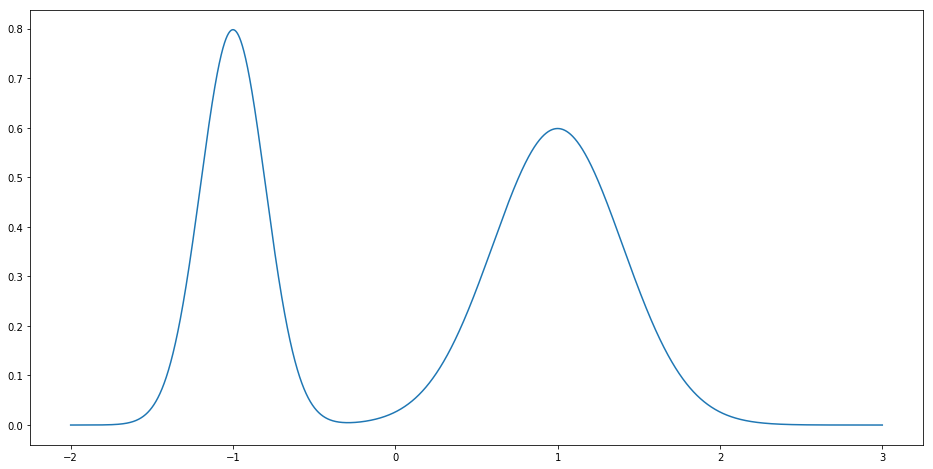

In [4]:
with sess.as_default():
    # prepare a gaussian mixture model
    gm = tfd.MixtureSameFamily(
                                mixture_distribution=tfd.Categorical(probs=[0.4, 0.6]),
                                components_distribution=tfd.Normal(loc=[-1, 1], #mean
                                                                   scale=[0.2, 0.4]) #sigma
                                )  

    # plot the generated mixture
    x = np.linspace(start=-2, 
                    stop=3,
                    num=int(1e4), 
                    dtype=np.float32)

    plt.figure(figsize=(16,8))
    plt.plot(x, gm.prob(x).eval())
    plt.show()

### Keras MDN

In [30]:
!pip install keras-mdn-layer

  Using cached https://files.pythonhosted.org/packages/6e/21/82a1402ff0a6cbd85fd4bde839737d7651e5a6cf6f2ada58fd2d7399caf1/keras_mdn_layer-0.2.2-py3-none-any.whl


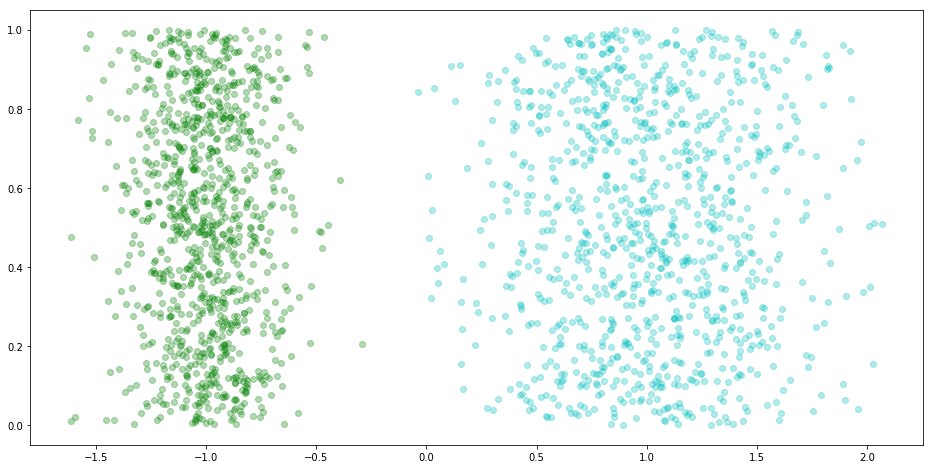

In [5]:
NSAMPLE = 1000

# distribution 1
y1_data = np.float32(np.random.uniform(0, 1, NSAMPLE))
x1_data = np.random.normal(-1,0.2,size=NSAMPLE)

# distribution 2
y2_data = np.float32(np.random.uniform(0, 1, NSAMPLE))
x2_data = np.random.normal(1,0.4,size=NSAMPLE)


plt.figure(figsize=(16, 8))
plt.plot(x1_data,y1_data,'go', x2_data, y2_data, 'co',alpha=0.3)
plt.show()

In [6]:
x_data = np.concatenate((x1_data,x2_data))
y_data = np.concatenate((y1_data,y2_data))

In [7]:
import keras
import mdn

N_HIDDEN = 16  # number of hidden units in the Dense layer
N_MIXES = 2  # number of mixture components
OUTPUT_DIMS = 1  # number of real-values predicted by each mixture component

model = keras.Sequential()
model.add(keras.layers.Dense(N_HIDDEN, batch_input_shape=(None, 1), activation='relu'))
model.add(mdn.MDN(OUTPUT_DIMS, N_MIXES))
model.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES), optimizer=keras.optimizers.Adam())
model.summary()

Using TensorFlow backend.
W1021 20:28:26.598930 4468069824 deprecation_wrapper.py:119] From /Users/rbali2/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1021 20:28:26.600475 4468069824 deprecation_wrapper.py:119] From /Users/rbali2/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1021 20:28:26.603960 4468069824 deprecation_wrapper.py:119] From /Users/rbali2/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1021 20:28:26.662778 4468069824 deprecation_wrapper.py:119] From /Users/rbali2/anaconda/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                32        
_________________________________________________________________
mdn_1 (MDN)                  (None, 6)                 102       
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(x=x_data, y=y_data, 
                    batch_size=16, epochs=500, 
                    validation_split=0.15,
                    verbose=0)

W1021 20:28:27.138973 4468069824 deprecation_wrapper.py:119] From /Users/rbali2/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1021 20:28:27.245200 4468069824 deprecation_wrapper.py:119] From /Users/rbali2/anaconda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



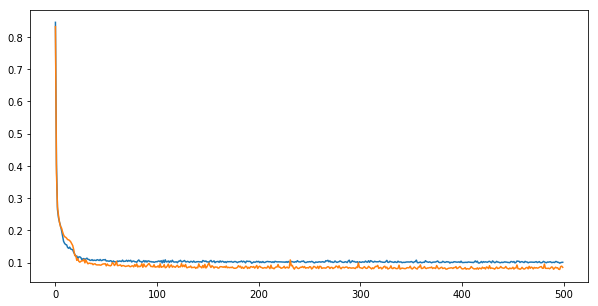

In [9]:
plt.figure(figsize=(10, 5))
#plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [10]:
x_test = np.float32(np.arange(-2,2,0.01))
NTEST = x_test.size
print("Testing:", NTEST, "samples.")
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector

# Make predictions from the model
y_test = model.predict(x_test)

y_samples = np.apply_along_axis(mdn.sample_from_output, 1, y_test, 1, N_MIXES,temp=1.0)

# Split up the mixture parameters 
mus = np.apply_along_axis((lambda a: a[:N_MIXES]),1, y_test)
sigs = np.apply_along_axis((lambda a: a[N_MIXES:2*N_MIXES]),1, y_test)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[2*N_MIXES:])),1, y_test)

Testing: 400 samples.


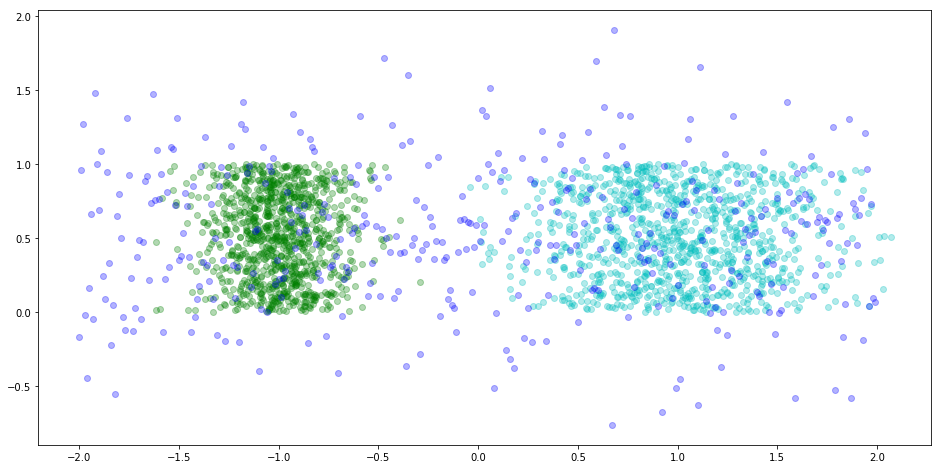

In [11]:
plt.figure(figsize=(16, 8))
plt.plot(x1_data,y1_data,'go', x2_data, y2_data, 'co', 
         x_test, y_samples[:,:,0], 'bo',alpha=0.3)
plt.show()

### Appendix

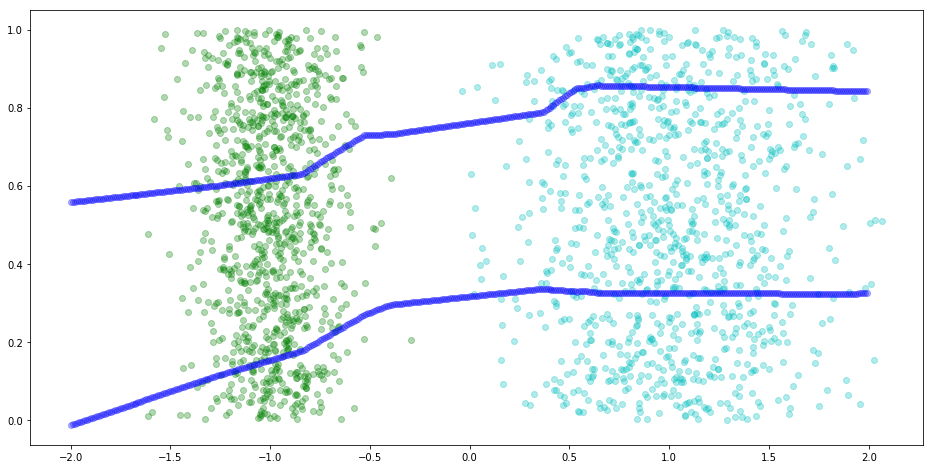

In [12]:
# Means
plt.figure(figsize=(16, 8))
plt.plot(x1_data,y1_data,'go', x2_data, y2_data, 'co', 
         x_test, mus,'bo',alpha=0.3)
plt.show()

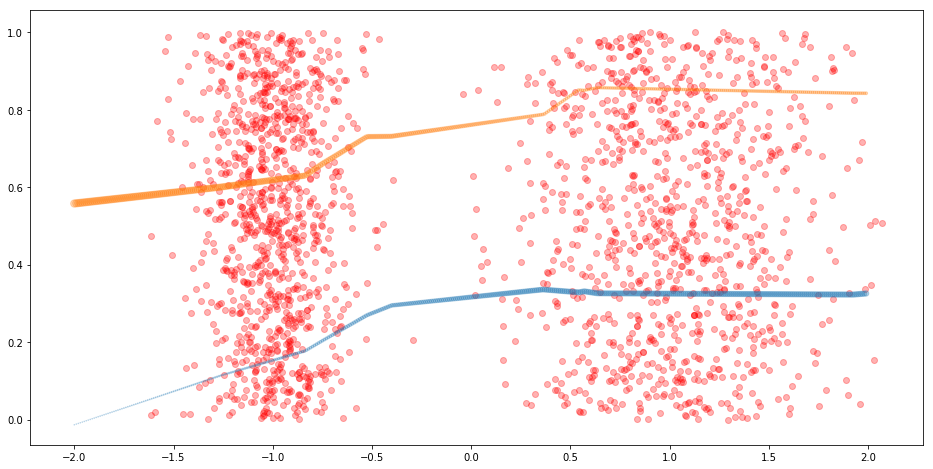

In [13]:
# Let's plot the variances and weightings of the means as well.
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(111)
ax1.scatter(x_data,y_data,marker='o', c='r', alpha=0.3)
for i in range(N_MIXES):
    ax1.scatter(x_test, mus[:,i], marker='o', s=200*sigs[:,i]*pis[:,i],alpha=0.3)
plt.show()

## Attention/Windowing

A typical ```Seq2Seq``` model usually makes use of RNN units like LSTMs or GRUs. During the forward pass, the encoder utilizes the input sequence to prepare a concise vector representation of the same. This representation is then utilized by the decoder to generate the output sequence.
Now it has been shown empirically in different studies that the representation prepared by the encoder seems to go for a toss as the sequence length increases. 

### Attention is all You Need

+ Simple idea to improve ```Seq2Seq``` architectures
+ Instead of discarding interim hidden states, Attention mechanism makes use of all internal states to prepare __Context Vector__
+ Decoder utilizes its internal state and this context vector to focus on the relevant parts of input sequence

<p>
    <img src="assets/attention.gif">
    <em>Image Source: https://machinetalk.org/2019/03/29/neural-machine-translation-with-attention-mechanism/</em>
</p>

### Handwriting and Attention

__Vanilla Architecture__
+ Initial architecture only utilizes previously predicted output to generate next step sampled from the mixtures
+ The results generated were close to understandable alphabets, yet model made mistakes like:
    - Overwriting
    - Generating unintelligible characters
    - Difficult to control what words the model would generate
    - Almost impossible to make the model follow a specific handwriting style

__Improved Architecture__
+ Add current input character as an additional auxiliary input. (Usually passed as a one hot encoded input)
+ Window(in the below figure) or the Guassian Window is a way for the model to focus its attention on specific character from all the distributions it is currently working with
+ This helps with:
    - Alignment of characters, i.e. the model can be made to generate the output we wanted it to (words, i.e.)
    - Lesser overwriting

<p>
    <img src="assets/model_attention.png">
    <em>Image Source: https://arxiv.org/pdf/1308.0850.pdf</em>
</p>

## Experiments

###  Biased Sampling

+ Focus model to generate specific handwriting styles
+ Simple hack is to reduce the variance but let the means be as-is for the mixtures
+ The result is a clear intelligible handwriting style as show in the below figure
+ Insight:
    - By reducing variance we are focusing towards a specific way of writing
    - The empirical result shows that this specific style is clearer to interpret and less cursive
    - Can we say analogous to Principal Components of all writing style :) !

<p>
    <img src="assets/hw_bias.png">
    <em>Image Source: https://arxiv.org/pdf/1308.0850.pdf</em>
</p>

### Priming

+ Way of making the model mimic specific writing style
+ Simple hack is to prime it with a specific style
+ This helps the model store that specific style
+ The generated output is almost similar to the expected style

__We could also combine bias and primed sampling, any ideas on how the output would be?__

<p>
    <img src="assets/hw_prime.png">
    <em>Image Source: https://arxiv.org/pdf/1308.0850.pdf</em>
</p>

## References

+ [Generating Sequences with RNNs, Alex Graves](https://arxiv.org/pdf/1308.0850.pdf)
+ [Neural Machine Translation by Jointly Learning to Align and Translate, Bengio et al](https://arxiv.org/abs/1409.0473)
+ [Attention Is All You Need, Vaswani et al](https://arxiv.org/abs/1706.03762)
+ [Handwriting Generation Demo](http://www.cs.toronto.edu/~graves/handwriting.cgi?)
+ [Chapter3, Hands on Transfer Learning, Dipanjan Sarkar, Raghav Bali, et al](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781788831307/3/ch03lvl1sec25/various-architectures)
+ [LSTM, Chris' blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
+ [Four Experiments in Handwriting with a Neural Network, distlill.pub](https://distill.pub/2016/handwriting/)
+ [Mixture Density Networks, Hardmaru/Otoro's Blog](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/)
+ [Keras MDN](https://github.com/cpmpercussion/keras-mdn-layer)
+ [Tensorflow Probability](https://www.tensorflow.org/probability)